In [2]:
# Import required modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegressionModel

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Fraud Detection with Logistic Regression") \
    .getOrCreate()

# Define the indexer for the 'type' column and the assembler for the features
indexer = StringIndexer(inputCol='type', outputCol='type_index')
feature_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_index']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Create a pipeline with the indexer and assembler
pipeline = Pipeline(stages=[indexer, assembler])

# Load the saved Logistic Regression model
model = LogisticRegressionModel.load("/data/logistic_model")  # Adjust the path accordingly

# Function to predict fraud using the Logistic Regression model
def predict_fraud(input_data):
    # Create a DataFrame from the input data
    input_df = spark.createDataFrame([input_data], schema=['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'])
    
    # Transform the input data using the pipeline
    input_transformed = pipeline.fit(input_df).transform(input_df)
    
    # Use the trained model to make predictions
    prediction = model.transform(input_transformed)
    
    # Return the prediction result
    return prediction.select('prediction').collect()[0][0]

# Evaluate the model on test data (optional, just for accuracy assessment)
def evaluate_model(test_data):
    predictions = model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(labelCol='isFraud', predictionCol='prediction', metricName='accuracy')
    accuracy = evaluator.evaluate(predictions)
    print(f"Model Accuracy on Test Data: {accuracy}")

# Example usage of the fraud prediction function
user_input = [355, 'Debit', 900, 9000, 8100, 7100, 8000]  # Replace with actual input data
result = predict_fraud(user_input)
print("Prediction:", "Fraud" if result == 1 else "Not Fraud")

# Optionally, show an example of evaluating the model's performance on test data (adjust test_data to your actual test data)
# test_data = <Your Test Data Here>
# evaluate_model(test_data)


Prediction: Not Fraud


In [2]:
# Import required modules
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

df = spark.read.csv('Synthetic_Financial_datasets_log.csv', header=True, inferSchema=True)
# Index the categorical column 'type'
indexer = StringIndexer(inputCol='type', outputCol='type_index')

# Select features for the model (you can adjust this based on your needs)
feature_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_index']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Create a pipeline
pipeline = Pipeline(stages=[indexer, assembler])
df_transformed = pipeline.fit(df).transform(df)

# Show transformed data
df_transformed.select('features', 'isFraud').show()

# Split the data into train and test sets
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)


# Assuming you already have the model and test_data loaded
# Perform predictions on the test data using the trained Logistic Regression model
predictions = model.transform(test_data)

# Show a sample of predictions (adjust the number of rows to display as needed)
predictions.select('features', 'isFraud', 'prediction').show(5)

# Evaluate the model: Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol='isFraud', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy on test set: {accuracy:.4f}")

# Evaluate the model: Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='isFraud', predictionCol='prediction', metricName='weightedPrecision')
precision = precision_evaluator.evaluate(predictions)
print(f"Precision on test set: {precision:.4f}")

# Evaluate the model: Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='isFraud', predictionCol='prediction', metricName='weightedRecall')
recall = recall_evaluator.evaluate(predictions)
print(f"Recall on test set: {recall:.4f}")

# Optionally, you can include other metrics such as F1 score if needed
f1_evaluator = MulticlassClassificationEvaluator(labelCol='isFraud', predictionCol='prediction', metricName='f1')
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score on test set: {f1_score:.4f}")


+--------------------+-------+
|            features|isFraud|
+--------------------+-------+
|[1.0,9839.64,1701...|      0|
|[1.0,1864.28,2124...|      0|
|[1.0,181.0,181.0,...|      1|
|[1.0,181.0,181.0,...|      1|
|[1.0,11668.14,415...|      0|
|[1.0,7817.71,5386...|      0|
|[1.0,7107.77,1831...|      0|
|[1.0,7861.64,1760...|      0|
|[1.0,4024.36,2671...|      0|
|[1.0,5337.77,4172...|      0|
|[1.0,9644.94,4465...|      0|
|[1.0,3099.97,2077...|      0|
|[1.0,2560.74,5070...|      0|
|[1.0,11633.76,101...|      0|
|[1.0,4098.78,5032...|      0|
|[1.0,229133.94,15...|      0|
|[1.0,1563.82,450....|      0|
|[1.0,1157.86,2115...|      0|
|[1.0,671.64,15123...|      0|
|[1.0,215310.3,705...|      0|
+--------------------+-------+
only showing top 20 rows

+--------------------+-------+----------+
|            features|isFraud|prediction|
+--------------------+-------+----------+
|[1.0,783.31,81503...|      0|       0.0|
|[1.0,1271.77,6973...|      0|       0.0|
|[1.0,2643.45,6434..

Confusion Matrix:
[[1227644   43300]
 [    178    1433]]


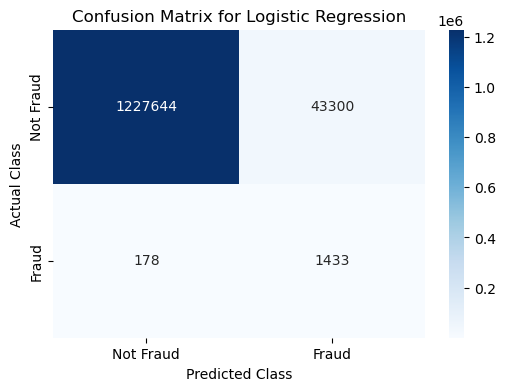

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np

# Get the predictions
predictions = model.transform(test_data)

# Calculate confusion matrix components
tp = predictions.filter((F.col('isFraud') == 1) & (F.col('prediction') == 1)).count()
tn = predictions.filter((F.col('isFraud') == 0) & (F.col('prediction') == 0)).count()
fp = predictions.filter((F.col('isFraud') == 0) & (F.col('prediction') == 1)).count()
fn = predictions.filter((F.col('isFraud') == 1) & (F.col('prediction') == 0)).count()

# Confusion matrix as a 2x2 numpy array
confusion_matrix = np.array([[tn, fp], [fn, tp]])

# Display confusion matrix values
print("Confusion Matrix:")
print(confusion_matrix)

# Plotting the confusion matrix using Matplotlib and Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])

plt.title('Confusion Matrix for Logistic Regression')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

# Display the plot
plt.show()


In [6]:
# Assuming `model` is the trained Logistic Regression model and `test_data` is the test dataset

# Step 1: Make predictions on the entire test dataset
predictions = model.transform(test_data)

# Step 2: Select the relevant columns (you can adjust this based on the columns you want to output)
output_df = predictions.select('step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'prediction')

# Show a sample of the output
output_df.show(5)

# Step 3: Write the result to a CSV file (adjust the path as needed)
output_path = "logistic_predictions.csv"  # Replace with the desired output path

# Save the output DataFrame as CSV (without overwriting)
output_df.coalesce(1).write.csv(output_path, header=True, mode='overwrite')

print(f"Predictions saved to {output_path}")


+----+-------+-------+-------------+--------------+--------------+--------------+-------+----------+
|step|   type| amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|prediction|
+----+-------+-------+-------------+--------------+--------------+--------------+-------+----------+
|   1|CASH_IN| 783.31|   8150331.93|    8151115.24|       2013.12|       1229.81|      0|       0.0|
|   1|CASH_IN|1271.77|    6973823.5|    6975095.27|     697456.73|    2719172.89|      0|       0.0|
|   1|CASH_IN|2643.45|   6434890.26|    6437533.71|       49974.0|       1891.79|      0|       0.0|
|   1|CASH_IN|6284.18|   7858787.73|     7865071.9|     328727.16|     277515.05|      0|       0.0|
|   1|CASH_IN|8679.13|   7087875.47|    7096554.61|      94438.08|      52415.15|      0|       0.0|
+----+-------+-------+-------------+--------------+--------------+--------------+-------+----------+
only showing top 5 rows

Predictions saved to logistic_predictions.csv
